# Apprenez une heuristique pour le Go

Dans ce TP noté, vous devrez déployer des methodes d'apprentissage automatique permettant d'évaluer la qualité de plateaux de GO.

Pour cela, vous disposerez de 41563 exemples de plateau de Go, tous générés par gnugo après quelques coups contre lui même avec un niveau de difficulté de 0. Par chaque plateau, nous avons lancé 100 matchs de gnugo contre lui même, toujours avec un niveau 0, et compté le nombre de victoires de noir et de blanc depuis ce plateau.

A noter, chaque "rollout" (un rollout et un déroulement possible du match depuis le plateau de référence) correspond à  des mouvements choisis aléatoirement parmis les 10 meilleurs mouvements possibles, en biasant le choix aléatoire par la qualité prédite du mouvement par gnugo (les meilleurs mouvements ont une plus forte probabilité d'être tirés).

Les données dont vous disposez sont brutes. Ce sera à  vous de proposer un format adéquat pour utiliser ces données en entrée de votre réseau neuronal. 

## Comment sera évalué votre modèle ?

Nous vous fournirons 6h avant la date de rendu un nouveau fichier contenant 1000 nouveaux exemples, qui ne contiendront pas les champs `black_wins`, `white_wins`, `black_points` et `white_points`. Vous devrez laisser, dans votre dépot de projet un fichier texte nommé `my_predictions.txt` ayant une prédiction par ligne (un simple flottant) qui donnera, dans le même ordre de la liste des exemples les scores que vous prédisez pour chacune des entrées du fichier que nous vous aurons donné. Il faudra laisser, dans votre feuille notebook (voir tout en dessous) la cellule Python qui aura créé ce fichier, pour que l'on puisse éventuellement refaire vos prédictions.

Bien entendu, vous nous rendrez également votre feuille jupyter **sous deux formats**, à  la fois le fichier `.ipynb` et le fichier `.html` nous permettant de lire ce que vous avez fait, sans forcément relancer la feuille. Nous prendrons en compte les résultats obtenus sur les prédictions mais aussi le contenu de vos notebooks jupyter.

### Comment sera noté ce TP ?

Il s'agit d'un TP noté, donc il ne faudra pas y passer trop de temps. Nous attendons des prédictions correctes mais surtout des choix justifiés dans la feuille. Votre feuille notebook sera le plus important pour la notation (n'hésitez pas à  mettre des cellules de texte pour expliquer pourquoi vous avez été amenés à  faire certains choix). Ainsi, il serait bien d'avoir, par exemple, les données (graphiques ou autre) qui permettent de comprendre comment vous avez évité l'overfitting.

Le fichier de vos prédiction sera évalué en se basant sur la qualité de vos prédictions. Nous mesurerons par exemple le nombre d'exemples dont votre prédiction donnera la bonne valeur à  5%, 10%, 20%, 35%, 50% pour estimer sa qualité.


## Mise en route !

Voyons  comment lire les données


In [4]:
# Import du fichier d'exemples

def get_raw_data_go():
    ''' Returns the set of samples from the local file or download it if it does not exists'''
    import gzip, os.path
    import json

    raw_samples_file = "samples-9x9.json.gz"

    if not os.path.isfile(raw_samples_file):
        print("File", raw_samples_file, "not found, I am downloading it...", end="")
        import urllib.request 
        urllib.request.urlretrieve ("https://www.labri.fr/perso/lsimon/ia-inge2/samples-9x9.json.gz", "samples-9x9.json.gz")
        print(" Done")

    with gzip.open("samples-9x9.json.gz") as fz:
        data = json.loads(fz.read().decode("utf-8"))
    return data

data = get_raw_data_go()
print("We have", len(data),"examples")

File samples-9x9.json.gz not found, I am downloading it... Done
We have 41563 examples


## Compréhension des données de chaque entrée

Voici une description de chaque exemple

In [5]:
def summary_of_example(data, sample_nb):
    ''' Gives you some insights about a sample number'''
    sample = data[sample_nb]
    print("Sample", sample_nb)
    print()
    print("Données brutes en format JSON:", sample)
    print()
    print("The sample was obtained after", sample["depth"], "moves")
    print("The successive moves were", sample["list_of_moves"])
    print("After these moves and all the captures, there was black stones at the following position", sample["black_stones"])
    print("After these moves and all the captures, there was white stones at the following position", sample["white_stones"])
    print("Number of rollouts (gnugo games played against itself from this position):", sample["rollouts"])
    print("Over these", sample["rollouts"], "games, black won", sample["black_wins"], "times with", sample["black_points"], "total points over all this winning games")
    print("Over these", sample["rollouts"], "games, white won", sample["white_wins"], "times with", sample["white_points"], "total points over all this winning games")

summary_of_example(data,10)

Sample 10

Données brutes en format JSON: {'depth': 8, 'list_of_moves': ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7'], 'black_stones': ['B7', 'C6', 'E5', 'C3'], 'white_stones': ['C8', 'E7', 'H7', 'G3'], 'rollouts': 100, 'black_wins': 60, 'black_points': 876.0, 'white_wins': 40, 'white_points': 378.0}

The sample was obtained after 8 moves
The successive moves were ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7']
After these moves and all the captures, there was black stones at the following position ['B7', 'C6', 'E5', 'C3']
After these moves and all the captures, there was white stones at the following position ['C8', 'E7', 'H7', 'G3']
Number of rollouts (gnugo games played against itself from this position): 100
Over these 100 games, black won 60 times with 876.0 total points over all this winning games
Over these 100 games, white won 40 times with 378.0 total points over all this winning games


## Données en entrée et en sortie de votre modèle final

Même si en interne, votre modèle va manipuler des tenseurs en numpy, vous devrez construire une boite noire qui prendra en entrée les coordonnées des pierres noires et blanches et donnera le pourcentage de chance pour noir de gagner depuis cette position. 

Ainsi, pour l'exemple `i` :
- Vous prendez en entree `data[i]["black_stones"]` et `data[i]["white_stones"]`
- Vous devrez prédire simplement `data[i]["black_wins"]/data[i]["rollouts"]`

Encore une fois, **attention** : en interne, il faudra absolument construire vos données formattées en matrices numpy pour faire votre entrainement. On vous demande juste ici d'écrire comment vous faites ces transformations, pour comprendre ce que vous avez décidé de mettre en entrée du réseau.

Voici le modèle de la fonction qui pourra être appelée, au final :


In [0]:
import numpy as np

def name_to_coord(s):
    assert s != "PASS"
    indexLetters = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'J':8}

    col = indexLetters[s[0]]
    lin = int(s[1:]) - 1
    return col, lin

In [0]:
#Fonction pour prédire la probabilté de victoire du joueur noir
def position_predict(black_stones, white_stones,model):

    M=np.zeros((9,9,2))
    to_predict = []
    # On transforme les données en argument en array 
    for i in white_stones:
      col, lin = name_to_coord(i)
      M[lin][col][1]=1
    for i in black_stones:
      col, lin = name_to_coord(i)
      M[lin][col][0]=1

    # Chaque configuration possède en réalité 7 autres config similaires
    for _ in range(4):
      to_predict.append(M)
      to_predict.append(np.flipud(M))
      M=np.rot90(M)
  
    to_predict=np.array(to_predict).reshape(np.array(to_predict).shape[0],9*9*2)
    list_of_prediction = model.predict(to_predict)
    pred=[]
    # On prédit le winrate du joueur noir pour chacune de ces 8 config similaires
    for j in range(8):
      pred.append(list_of_prediction[j][0])

    pred.sort()
    
    # On renvoie la médiane des 8 valeurs prédites
    prediction = statistics.median(pred)
    return round(prediction,2)

# Par exemple, nous pourrons appeler votre prédiction ainsi

#print("Prediction this sample:")
#summary_of_example(data, 10)
#print()
#prediction = position_predict(data[10]["black_stones"], data[10]["white_stones"])
#print("You predicted", prediction, "and the actual target was", data[10]["black_wins"]/data[10]["rollouts"])

# Ainsi, pour le rendu, en admettant que newdata soit le fichier json contenant les nouvelles données que 
# l'on vous donnera 24h avant la fin, vous pourrez construire le fichier resultat ainsi

def create_result_file(newdata):
    ''' Exemple de méthode permettant de générer le fichier de resultats demandés. '''
    resultat  = [position_predict(d["black_stones"], d["white_stones"]) for d in newdata]
    with open("my_predictions.txt", "w") as f:
         for p in resultat:
            f.write(str(p)+"\n")



The CDF curve shows that black has more chances to win, globally


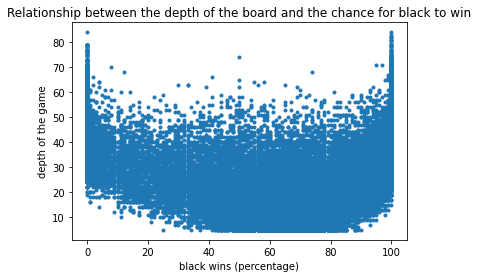

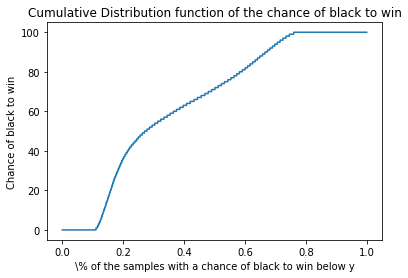

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.title("Relationship between the depth of the board and the chance for black to win")
plt.plot([sample["black_wins"] for sample in data],[sample["depth"] for sample in data], '.')
plt.xlabel("black wins (percentage)")
plt.ylabel("depth of the game")


# Cumulative Distribution function of the chance of black to win
cdf_wins = sorted([sample["black_wins"] for sample in data])
plt.figure()
plt.plot([x/len(cdf_wins) for x in range(len(cdf_wins))], cdf_wins)
plt.title("Cumulative Distribution function of the chance of black to win")
plt.xlabel("\% of the samples with a chance of black to win below y")
plt.ylabel("Chance of black to win")
print("The CDF curve shows that black has more chances to win, globally")

# First steps: transform all the data into numpy arrays to feed your neural network

Advices:
- do not use only a 9x9 matrix as input. Use at least to planes to encode the board. One plane for black and one plane for white (typically with a 1 if there is a black stone for the first plane and with a 1 if there is a white stone for the second plane). The dimension of an input should be at least `[9,9,2]`.
- consider to enrich your dataset with all symmetries and rotations. You should be able to multiply the number of samples to consider: any rotation of the board should have the same score, right?
- what should happen on the score if you switch the colors? To know which player has to play next, you can check, for a sample, the parity of the length of the list `data[i]["list_of_moves"]` (an odd length list would mean that white is the next player. An even length list means that black has to play).
- work on enlarging and preparing your data only once. Once all you input data is setup as a big Numpy matrix, you may want to save it for speeding up everything. You can use, for instance `numpy.rot90()` and `numpy.flipud()` to generate all the symmetries



In [0]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, Conv2D, BatchNormalization, MaxPooling2D
import tensorflow.keras.optimizers as optimizers
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

L_moves = []
L_black_win=[]

# Transformation des datas en array utilisables
for d in data:
  M=np.zeros((9,9,2))

  L_white_moves=d["white_stones"]
  for i in L_white_moves:
    col, lin = name_to_coord(i)
    M[col][lin][1]=1
  
  L_black_moves=d["black_stones"]
  for i in L_black_moves:
    col, lin = name_to_coord(i)
    M[col][lin][0]=1

  # Chaque config possède 7 autres config similaires
  for _ in range(4):
    L_moves.append(M)
    L_moves.append(np.flipud(M))
    M=np.rot90(M)
  # Avec le même winrate pour le joueur noir
  for _ in range(8):
    L_black_win.append(d["black_wins"]/d["rollouts"])

# On garde 33% des données brutes en guise de validation / test
X_train, X_test, y_train, y_test = train_test_split(L_moves, L_black_win, test_size=0.33, random_state=42)
print("Set ok")


Set ok


# Second steps: build your neural network and train it

Don't forget to check overfitting, ...

*advices* :
- you need to test Dense and Conv2D layers (the best models may contain convolution layers=
- if you use convolution layers, be sure not to downsize your board. Applying a filter should keep the original size of the board (9x9), otherwise you would somehow forget the stones on the borders
- you will use like 33% of your input sample for validation. However, the final goal is to score new data that will be given in addition to the actual data. So, you should use the 33% splitting rule to set up your network architecture and, once you fixed it, you should train your final model on the whole set of data, crossing your fingers that it will generalize well.
- Warning: if you launch the fit function from keras more than once, it will not reset the weights and the biases of your neural network. It's good news because you can add more and more epochs to your model, but be careful about the training/test sets: each time you call fit() with validation_split set up to something like 0.33, it will choose a **new** partition of the samples. So you are breaking your validation/training partition! We advice you to use the `sklearn.model_selection.train_test_split()` method to split the set of examples just once and then use the parameter `validation_data` in the call for `fit()`.  Thus you will be able to call it multiple time.


In [0]:
# Adaptation des données d'entrainement / test pour notre réseau
x3_train= np.array(X_train).reshape((np.array(X_train).shape[0],9*9*2))
x3_test= np.array(X_test).reshape((np.array(X_test).shape[0],9*9*2))

In [0]:
# Configuration du modèle avec 6 Dense layers
model = Sequential([
    Dense(4096, activation='sigmoid', input_shape=(9*9*2,)),
    Dense(2048, activation='tanh'),
    Dense(1024, activation='sigmoid'),
    Dense(256, activation='tanh'),
    Dense(64, activation='sigmoid'),
    Dense(1, activation='tanh')
])

# metric utile pour savoir quelle est notre précision en %
def my_metric(y_true,y_pred):
  diff = y_true - y_pred
  return((1-abs(diff))*100)

adam = optimizers.Adam(lr=0.0001)

model.compile(loss='MSE', optimizer=adam, metrics=[my_metric]) 

model.fit(np.asarray(x3_train),np.asarray(y_train),batch_size=100,epochs=250, validation_data=(np.asarray(x3_test), np.asarray(y_test)))

model.save('my_model.h5')
model.summary()

In [0]:
# Cellule utile pour continuer l'entrainement du modèle
model = tf.keras.models.load_model('my_model.h5', custom_objects={'my_metric': my_metric})
model.fit(np.asarray(x3_train),np.asarray(y_train),batch_size=100,epochs=10, validation_data=(np.asarray(x3_test), np.asarray(y_test)))

model.save('my_model.h5')

In [0]:
# Cellule pour arranger les données tests et faire la médiane sur 8 prédictions au lieu d'une seule
model = tf.keras.models.load_model('model_cheat_9299.h5', custom_objects={'my_metric': my_metric})
new_x3_test = []
for i in range(len(X_test)):
  M=X_test[i]
  for _ in range(4):
    new_x3_test.append(M)
    new_x3_test.append(np.flipud(M))
    M=np.rot90(M)
def change(M):
  new_M=[]
  for k in range(2):
    N=[]
    for i in range(len(M)):
      L=[]
      for j in range(len(M[0])):
        L.append(M[i][j][k])
      N.append(L)
    new_M.append(N)
  return np.array(new_M)
  
new_x3_test=np.array(new_x3_test).reshape(np.array(new_x3_test).shape[0],9*9*2)

In [0]:
# Cellule d'affichage et de calcul de précision sur les données tests
import statistics

y_predS = model.predict(np.asarray(new_x3_test))

dec = 8

accuracy = 0
accuracy2 = 0
L1=0
L5=0
L10=0
L15=0
L20=0
Lsup=0
for i in range(0,len(y_predS),dec):
  pred=[]
  pred2=0
  for j in range(dec):
    pred.append(y_predS[i+j][0])
    pred2+=y_predS[i+j][0]
  new_accuracy = abs(statistics.median(pred)-y_test[int(i/dec)])*100
  new_accuracy2 = abs(pred2/8-y_test[int(i/dec)])*100
  accuracy+= (100-new_accuracy)
  accuracy2+= (100-new_accuracy2)
  if(new_accuracy <= 1):
    L1+=1
  if(new_accuracy <= 5):
    L5+=1
  if(new_accuracy <= 10):
    L10+=1
  if(new_accuracy <= 15):
    L15+=1
  if(new_accuracy <= 20):
    L20+=1
  if(new_accuracy > 20):
    Lsup+=1

# Affichage de la précision en utilisant la médiane / la moyenne
print("Mediane : ",accuracy/len(y_test))
print("Moyennne : ",accuracy2/len(y_test))

# Affichage des valeurs dans des intervalles de précisions donnés
print("1% :",L1)
print("5% :",L5)
print("10% :",L10)
print("15% :",L15)
print("20% :",L20)
print("> 20% :",Lsup)

Mediane :  91.75305994044056
Moyennne :  91.21097331698087
1% : 28743
5% : 56153
10% : 77242
15% : 90808
20% : 98754
> 20% : 10973


# Last step

Prepare your model to predict the set of new data to predict, you will have only 6 hours to push your predictions.

(may be you would like to express, when guessing the percentage of wins for blacks, that it should reflect the fact that this score should be the same for all the symmetries you considered)...

In [9]:
import gzip, os.path
import json

raw_samples_file = "positions-to-evaluate-9x9.json.gz"
new_data_set = ""
new_data_result = ""

if not os.path.isfile(raw_samples_file):
    print("File", raw_samples_file, "not found, I am downloading it...", end="")
    import urllib.request 
    urllib.request.urlretrieve ("https://www.labri.fr/perso/lsimon/ia-inge2/positions-to-evaluate-9x9.json.gz", "positions-to-evaluate-9x9.json.gz")
    print(" Done")

with gzip.open("positions-to-evaluate-9x9.json.gz") as fz:
    new_data_set = json.loads(fz.read().decode("utf-8"))


print("New set of data downloaded !")

File positions-to-evaluate-9x9.json.gz not found, I am downloading it... Done
New set of data downloaded !


In [0]:
# Import du modèle via un lien, il est préférable de l'importer à la main !
import urllib.request
def my_metric(y_true,y_pred):
  diff = y_true - y_pred
  return((1-abs(diff))*100)
if not os.path.isfile("new_model.h5"):
  urllib.request.urlretrieve("https://srv-file6.gofile.io/download/3khcKa/model_cheat_9299.h5", "new_model.h5")
print("Model downloaded !")

Model downloaded !


In [11]:
# Chargement du modèle et prédictions
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, Conv2D, BatchNormalization, MaxPooling2D
import tensorflow.keras.optimizers as optimizers
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import statistics

def my_metric(y_true,y_pred):
  diff = y_true - y_pred
  return((1-abs(diff))*100)

model = tf.keras.models.load_model('new_model.h5', custom_objects={'my_metric': my_metric})
predictions = open("my_predictions.txt", "a")
# Lancement des prédictions
pred = []
for d in new_data_set:
  val = abs(position_predict(d["black_stones"],d["white_stones"],model))
  pred.append(val)
  predictions.write(str(val))
  predictions.write("\n")

predictions.close()
print("Predictions done !")

Predictions done !


In [0]:
# Visualisation de statistiques quand on connait le résultat attendu !
import statistics

dec = 8

accuracy = 0
L1=0
L5=0
L10=0
L15=0
L20=0
Lsup=0
for i in range(len(pred)):
  new_accuracy = round(abs(pred[i]-res[i])*100,2)
  accuracy += 100-new_accuracy
  if(new_accuracy <= 1):
    L1+=1
  if(new_accuracy <= 5):
    L5+=1
  if(new_accuracy <= 10):
    L10+=1
  if(new_accuracy <= 15):
    L15+=1
  if(new_accuracy <= 20):
    L20+=1
  if(new_accuracy > 20):
    Lsup+=1

# Affichage de la précision en utilisant la médiane
print("Précision : ",accuracy/len(res))

# Affichage des valeurs dans des intervalles de précisions donnés
print("1% :",L1)
print("5% :",L5)
print("10% :",L10)
print("15% :",L15)
print("20% :",L20)
print("> 20% :",Lsup)

Précision :  89.28
1% : 32
5% : 58
10% : 67
15% : 76
20% : 81
> 20% : 19
